In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import Isomap
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('churn_false.csv')
df

,Unnamed: 0,Phone_Number,Account_Length,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,...,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn,Cluster,PCA1,PCA2,Day_Eve_Charge_Ratio,Night_Intl_Charge_Ratio
0,0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,...,10.0,3,2.70,1,False,1,-1.130000,-0.261887,2.685936,4.077778
1,1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,...,13.7,3,3.70,1,False,1,-1.906776,-0.641235,1.652828,3.094595
2,2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,...,12.2,5,3.29,0,False,1,-2.791505,-1.783122,4.017476,2.224924
3,3,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,...,10.1,3,2.73,3,False,1,-3.283894,-1.073900,2.247423,3.080586
4,4,391-8027,118,0,223.4,98,37.98,220.6,101,18.75,...,6.3,6,1.70,0,False,1,-2.080675,0.139076,2.025600,5.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31689,36072,796-5759,228,0,222.8,92,29.82,280.0,202,22.28,...,9.6,2,2.89,2,False,1,0.028126,1.697858,1.338420,7.643599
31690,36073,779-7579,62,0,228.8,92,29.88,292.8,92,26.88,...,20.2,2,2.82,8,False,1,-0.400837,-0.165286,1.111607,3.411348
31691,36074,789-9756,222,0,228.2,60,22.82,229.8,289,28.26,...,6.2,2,2.62,2,False,1,-1.100422,-0.297205,0.807502,0.870229
31692,36075,798-5885,88,0,282.2,222,82.88,208.8,220,22.82,...,9.8,8,2.82,8,False,0,1.591961,1.143648,3.631902,7.333333


In [3]:
# Ensure 'Churn' column is properly formatted
df['Churn'] = df['Churn'].astype(int)

In [4]:
# Select relevant numerical columns for clustering
numerical_cols = [
    'Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 
    'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 
    'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls'
]

X = df[numerical_cols]

In [5]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Perform hierarchical clustering and create a dendrogram
linked = linkage(X_scaled, method='ward')

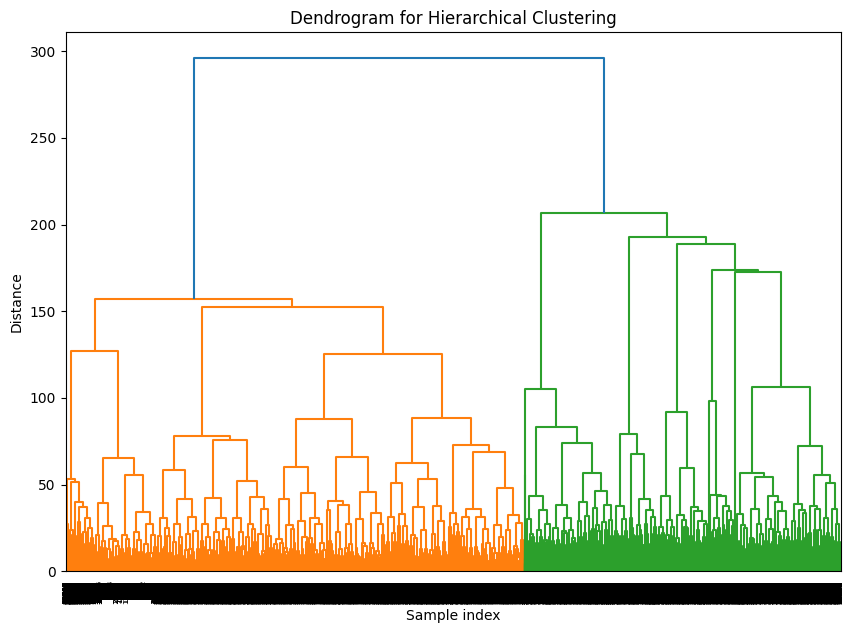

In [7]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [8]:
# Apply Agglomerative Clustering with the desired number of clusters, e.g., 3
optimal_clusters = 3
hierarchical_cluster = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
df['Cluster'] = hierarchical_cluster.fit_predict(X_scaled)

In [9]:
# Visualize the clusters using ISOMAP
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)
df['ISOMAP1'] = X_isomap[:, 0]
df['ISOMAP2'] = X_isomap[:, 1]

In [10]:
# Calculate Customer Lifetime Value (CLV)
df['CLV'] = df['Day_Charge'] + df['Eve_Charge'] + df['Night_Charge'] + df['Intl_Charge']

In [11]:
# Define cluster names based on your analysis
cluster_names = {
    0: 'Potential Low Value Customers',
    1: 'Potential Medium Value Customers',
    2: 'Potential High Value Customers'
}

# Map clusters to descriptive names
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

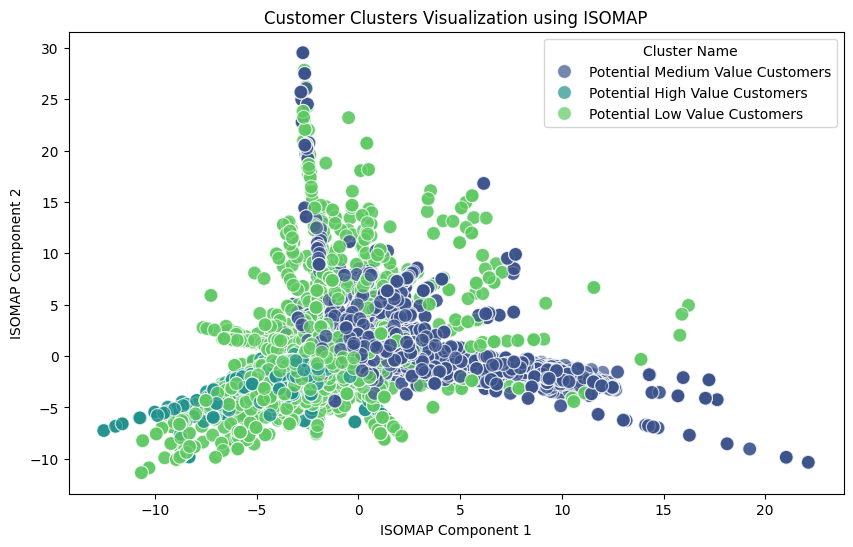

In [12]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ISOMAP1', y='ISOMAP2', hue='Cluster_Name', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Clusters Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.legend(title='Cluster Name', loc='best')
plt.show()

In [13]:
# Cluster analysis: describe statistics and CLV
cluster_analysis = {}
for i in range(optimal_clusters):
    cluster_name = cluster_names.get(i, f'Cluster {i}')
    cluster_data = df[df['Cluster'] == i][numerical_cols].describe()
    cluster_clv_mean = df[df['Cluster'] == i]['CLV'].mean()
    churn_rate = df[df['Cluster'] == i]['Churn'].mean() * 100  # Convert to percentage
    cluster_analysis[cluster_name] = {
        'Data Description': cluster_data,
        'Average CLV': cluster_clv_mean,
        'Churn Rate': churn_rate
    }

# Count the number of records in each cluster
cluster_counts = df['Cluster_Name'].value_counts()

In [14]:
# Results
print("Cluster Analysis Summary:")
for cluster_name, analysis in cluster_analysis.items():
    print(f"\n{cluster_name}:\n")
    print(analysis['Data Description'])
    print(f"Average CLV: {analysis['Average CLV']:.2f}")
    print(f"Churn Rate: {analysis['Churn Rate']:.2f}%")

print("\nNumber of Records in Each Cluster:")
print(cluster_counts)

Cluster Analysis Summary:

Potential Low Value Customers:

       Account_Length  VMail_Message     Day_Mins    Day_Calls   Day_Charge  \
count     9228.000000    9228.000000  9228.000000  9228.000000  9228.000000   
mean       164.080949      21.362375   264.894168   158.385674    58.676211   
std        103.451317      33.640605    43.359744    92.789720    30.398632   
min          2.000000       0.000000    80.800000    20.000000     9.890000   
25%         82.000000       0.000000   223.000000    88.000000    28.660000   
50%        202.000000       0.000000   282.200000    99.000000    80.620000   
75%        244.000000      29.000000   292.200000   222.000000    82.980000   
max        329.000000     211.000000   402.200000   329.000000   211.990000   

          Eve_Mins    Eve_Calls   Eve_Charge   Night_Mins  Night_Calls  \
count  9228.000000  9228.000000  9228.000000  9228.000000  9228.000000   
mean    269.510090   163.422085    26.927446   269.832651   162.875704   
std    